<a href="https://colab.research.google.com/github/averma12/Deep-Learning/blob/master/Transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai

    100% |████████████████████████████████| 17.3MB 2.4MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [0]:
from fastai import *
from fastai.vision import *

In [0]:
bs = 64

In [0]:
path = untar_data(URLs.PETS)
path_anno = path/'annotations'
path_img = path/'images'
fnames = get_image_files(path_img)
np.random.seed(2)
pat = re.compile(r'/([^/]+)_\d+.jpg$')

In [4]:
pat

re.compile(r'/([^/]+)_\d+.jpg$', re.UNICODE)

In [0]:
??cnn_learner

In [0]:
import torchvision.models as models
torch.backends.cudnn.benchmark = True

In [0]:
def cnn_learner_new(data:DataBunch, base_arch:Callable, cut:Union[int,Callable]=None, pretrained:bool=True,
                lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, custom_head:Optional[nn.Module]=None,
                split_on:Optional[SplitFuncOrIdxList]=None, bn_final:bool=False, init=nn.init.kaiming_normal_,
                concat_pool:bool=True, **kwargs:Any)->Learner:
    "Build convnet style learner."
    meta = cnn_config(base_arch)
    model = create_cnn_model(base_arch, data.c, cut, pretrained, lin_ftrs, ps=ps, custom_head=custom_head,
        split_on=split_on, bn_final=bn_final, concat_pool=concat_pool)
    learn = Learner(data, model, **kwargs)
    learn.split(split_on or meta['split'])
    if pretrained: learn.freeze()
    if init: apply_init(model[1], nn.init.kaiming_normal_)
    return learn

In [10]:
meta = cnn_config(models.resnet18)

NameError: ignored

In [13]:
tfms = get_transforms()
type(tfms)

tuple

In [14]:
len(tfms)

2

In [0]:
def get_ex(): return open_image(path/'images/beagle_192.jpg')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]


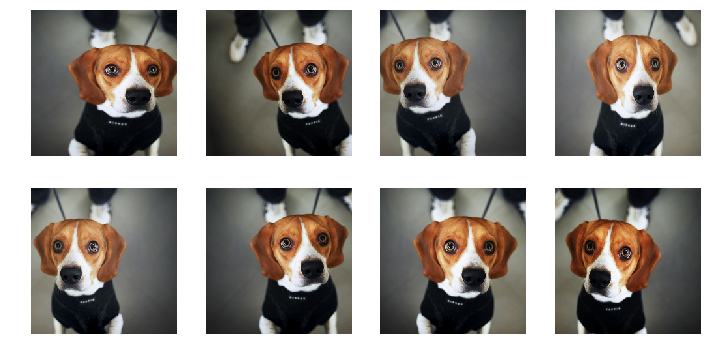

In [16]:
plots_f(2, 4, 12, 6, size=224)

In [0]:
??get_transforms

In [0]:
def get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10., max_zoom:float=1.1,
                   max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75,
                   p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    res = [rand_crop()]
    if do_flip:    res.append(dihedral_affine() if flip_vert else flip_lr(p=0.5))
    if max_warp:   res.append(symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine))
    if max_rotate: res.append(rotate(degrees=(-max_rotate,max_rotate), p=p_affine))
    if max_zoom>1: res.append(rand_zoom(scale=(1.,max_zoom), p=p_affine))
    if max_lighting:
        res.append(brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting))
        res.append(contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting))
    #       train                   , valid
    return (res + listify(xtra_tfms), [crop_pad()])

**Rotation**

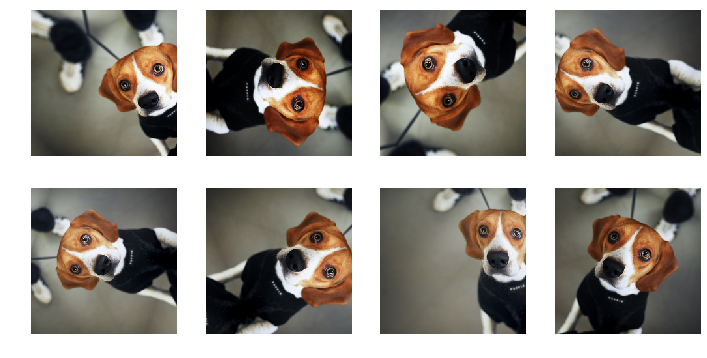

In [21]:
tfms_rot = get_transforms(max_rotate=180)
plots_f(2, 4, 12, 6, size=224)

In [22]:
tfms_rot

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-180, 180)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resol

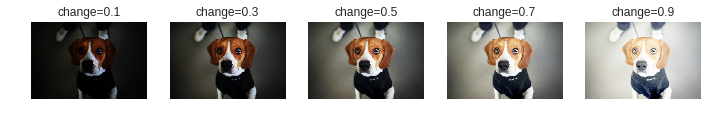

In [23]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for change, ax in zip(np.linspace(0.1,0.9,5), axs):
    brightness(get_ex(), change).show(ax=ax, title=f'change={change:.1f}')